<a href="https://colab.research.google.com/github/SeungYeon2000/pytorch/blob/main/Chap5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data 얻기 절차 (케플러와 동일)**
1. data 얻기(from 기존 data)
2. 시각화
3. 가장 간단한 모델 선정
4. data split
5. 잠정적 특징, 사이즈로 시작, 반복
6. validation
7. look back

# **1. Gatering Some Data**

In [6]:
import numpy as np
import torch

In [7]:
# In[2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]        # temperatures in Celsius
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]        # values our unknown units
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

# **2. Visiualizing the data**

# **3. Choosing a linear model as a first try (가장 간단한 모델 선정)**
t_c = w * t_u + b로 두기 (w = weight, b = bias)
-> w와 b를 찾아야 loss function 이 최소가 됨

loss 계산 : 실제값과 예상값의 차이 (t_p - t_c,  t_p = predicted temperature), 항상 양수가 되어야하므로 \t_p - t_c\나 (t_p - t_c)^2로 표현해서 error 줄일 수 있음

여기서 절댓값보단 제곱형으로 쓸 것



In [8]:
# In[3]:
def model(t_u, w, b):
    return w * t_u + b      # t_u : input tensor, w : weight parameter, b : bias parameter

In [9]:
# In[4]
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [10]:
# In[5]
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [11]:
# In[6]
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

# **Broadcasting**

In [4]:
#In[7]:
x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2, 1, 1)
print(f"shapes: x: {x.shape}, y: {y.shape}")
print(f" z: {z.shape}, a: {a.shape}")
print("x * y:", (x * y).shape)
print("y * z:", (y * z).shape)
print("y * z * a:", (y * z * a).shape)

shapes: x: torch.Size([]), y: torch.Size([3, 1])
 z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])
x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


# **4. Optimizing the loss function (gradient descent algorithm)**

In [12]:
# In[8]:
delta = 0.1
loss_rate_of_change_w = \     # 역슬래쉬가 왜 나와..?
(loss_fn(model(t_u, w + delta, b), t_c) -
loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

w에서 unit increase -> change in loss (negative : w 증가시켜서 손실 줄여야/ positive : w 줄여서 손실 줄여야)

scaling factor (how much?) = learning_rate로 표기



In [13]:
# In[9]:
learning_rate = 1e-2
w = w - learning_rate * loss_rate_of_change_w

In [14]:
# In[10]:
loss_rate_of_change_b = \
(loss_fn(model(t_u, w, b + delta), t_c) -
loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)
b = b - learning_rate * loss_rate_of_change_b

In [16]:
# In[11]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)
    return dsq_diffs

In [17]:
# In[12]:
def dmodel_dw(t_u, w, b):
    return t_u

In [19]:
# In[13]:
def dmodel_db(t_u, w, b):
    return 1.0

In [21]:
# In[14]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])    #summation = broadcasting의 반대(우리가 parameter들을 모델의 input vector 전체에 적용할 때)

# **5. Iterating**
training iteration during which we update the parameters = epoch

model convergence에 관한 내용

In [22]:
# In[15]
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        print('Epoch %d, Loss %f' % (epoch, float(loss))) # <3>
            
    return params

In [23]:
# In[17]
def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

만약 loss가 무한으로 가면 params가 너무 큰 값이 나오면서 발산.

-> learning_rate * grad를 어떻게 제한할 수 있을까? : learning_rate 값 줄이기

In [25]:
# In [17]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-4, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 1763.884766
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090515
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4666,  16.5122])
...
Epoch 10, Loss 29.105247
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582
    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022667
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

위 코드라면 loss가 무한은 아니지만 loss가 너무 느리게 줆.
+ weight가 bias보다 50배는 커서 적당한 learning_rate 찾기 힘듦.

-> 따라서 다른 formulation 필요 : t_u * 0.1 곱하기(input의 범위가 -1.0 ~ 1.0이도록)

In [26]:
# In [19]:
t_un = 0.1 * t_u      # t_un : normalized version이라는 뜻

In [27]:
# In [20]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, # <1>
    t_c = t_c)

# leraning_rate가 1e-2로 동일하지만 parameters가 blow up 하지 않음!

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030489
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941877
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])


tensor([ 2.7553, -2.5162])

In [29]:
# In [21]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, 
    t_c = t_c,
    print_params = False)

params

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574913
Epoch 3, Loss 30.871077
...
Epoch 10, Loss 29.030489
Epoch 11, Loss 28.941877
...
Epoch 99, Loss 22.214186
Epoch 100, Loss 22.148710
...
Epoch 4000, Loss 2.927680
Epoch 5000, Loss 2.927648


tensor([  5.3671, -17.3012])

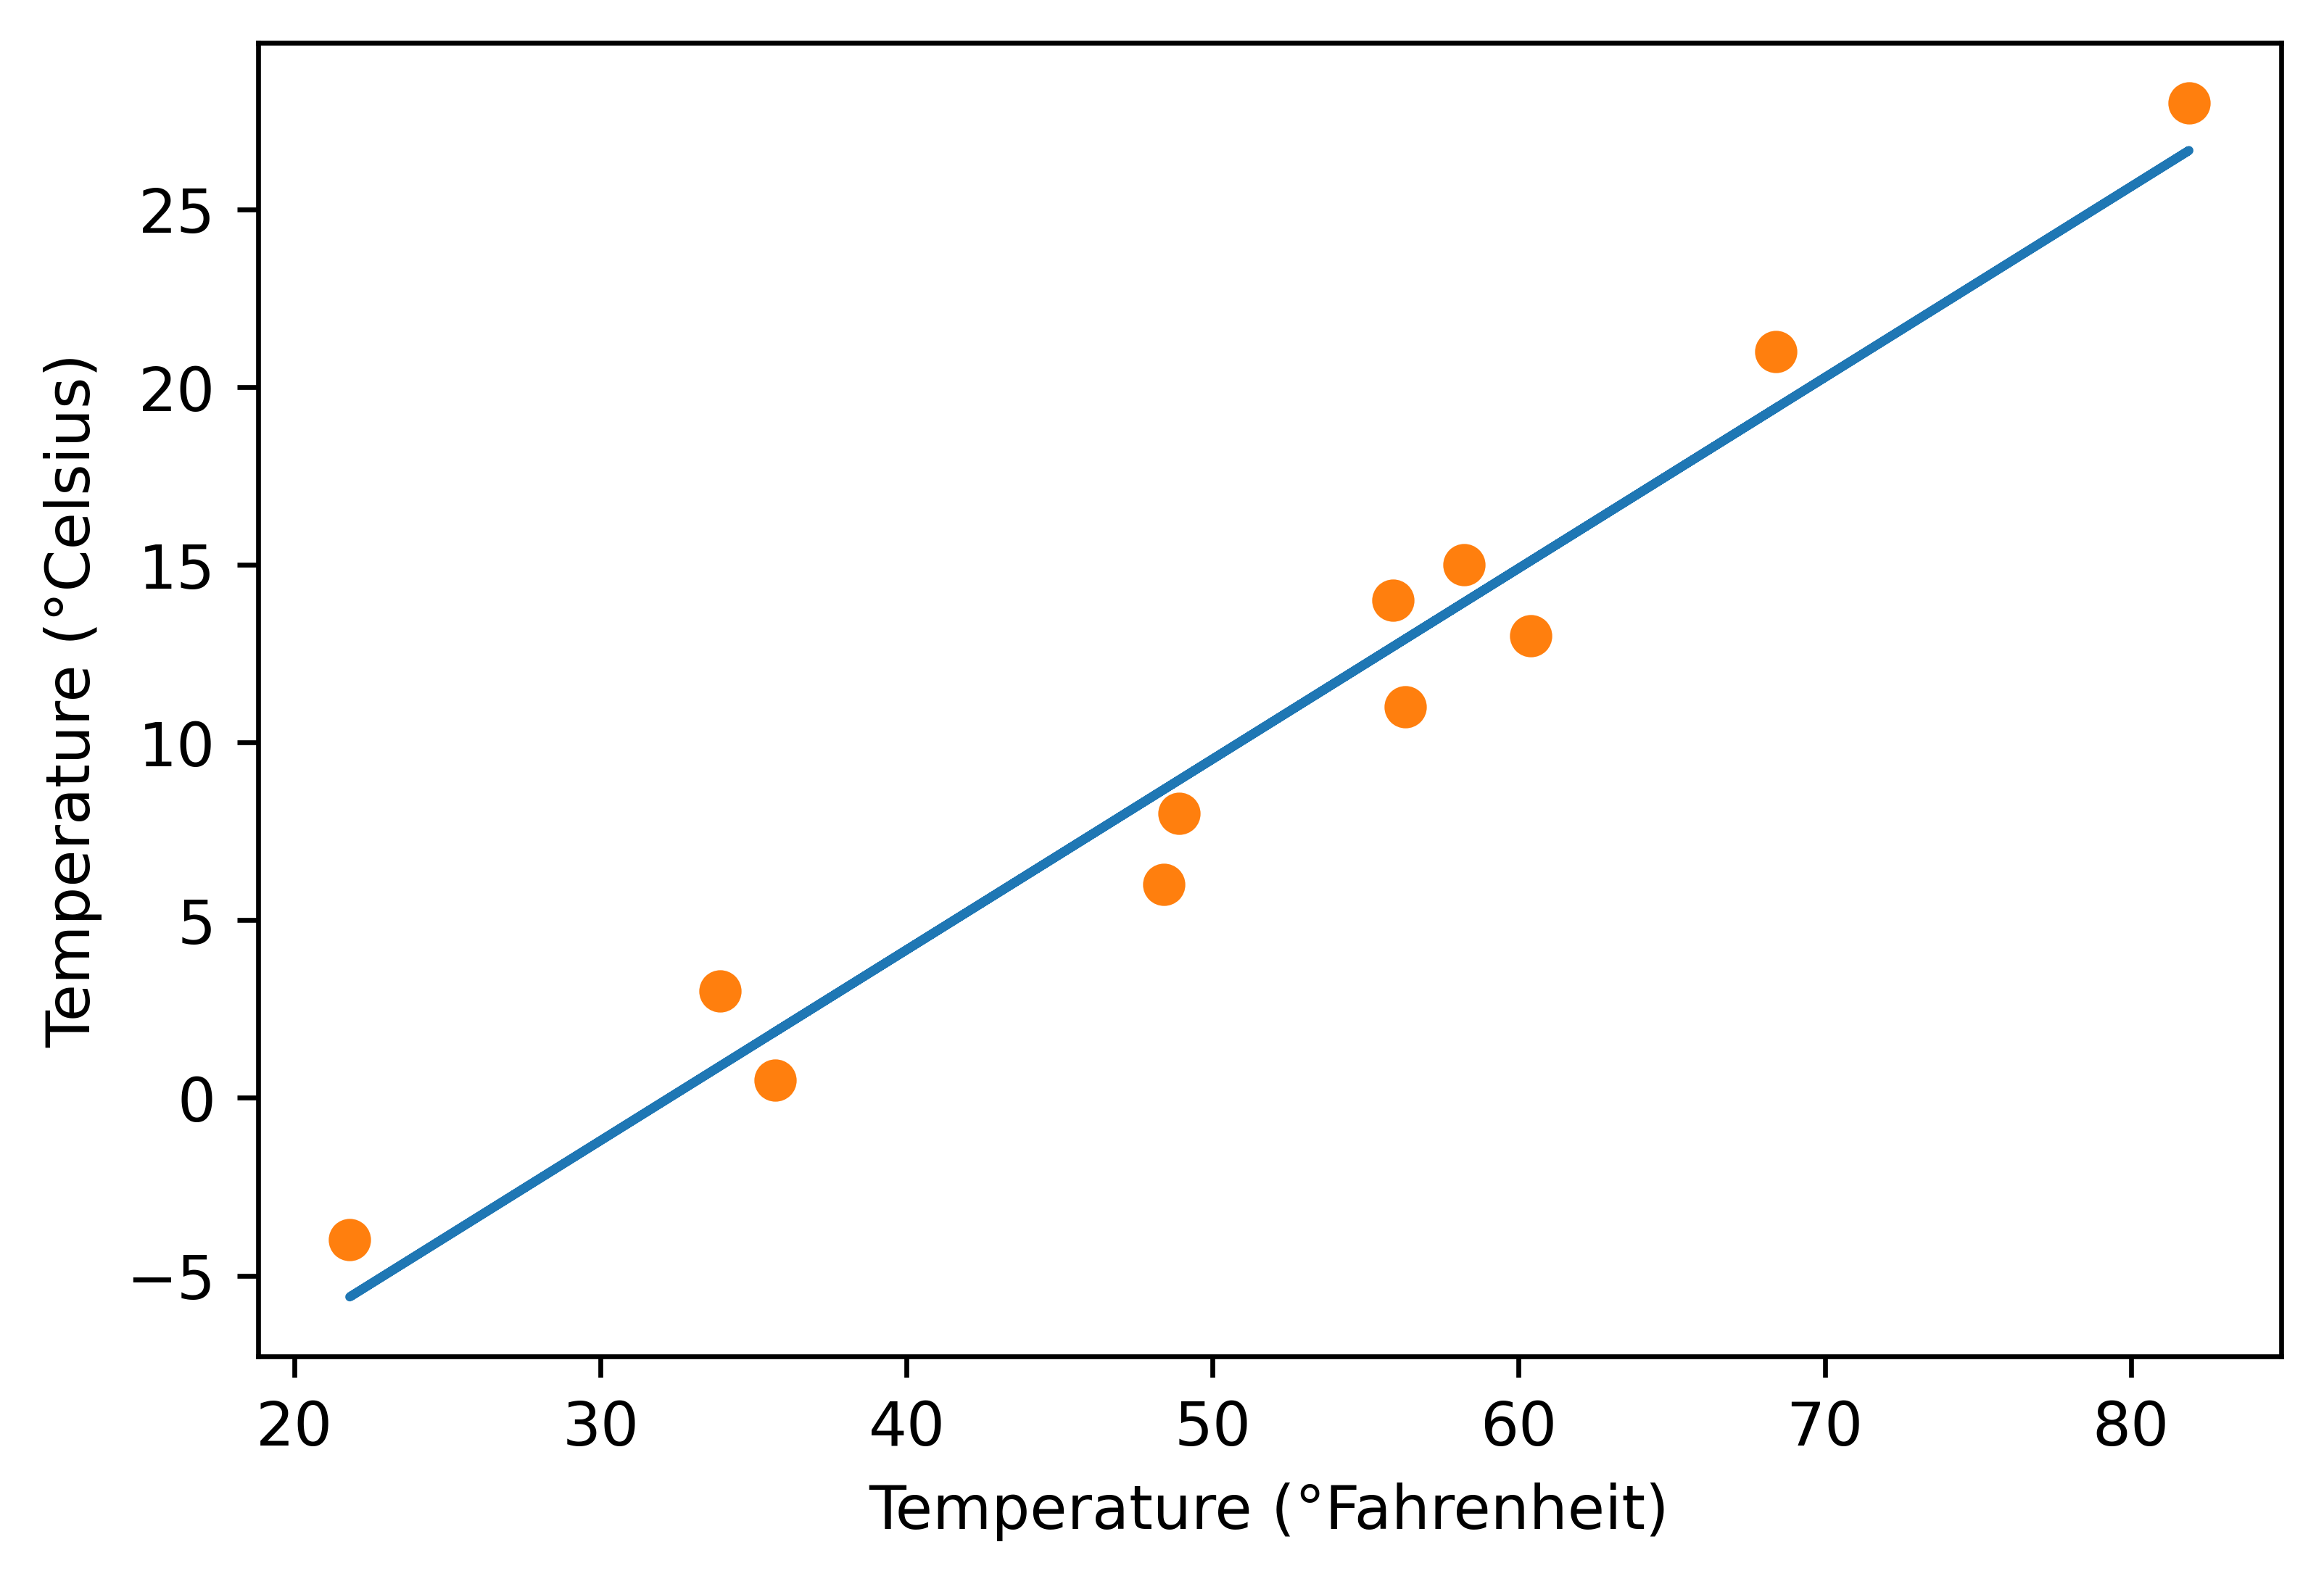

In [30]:
# In [22]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)  # unknown units, *params = pass the elements of params as individual arguments/ same as model(t_un, params[0], params[1])

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # raw unknown values
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")  # bookskip


In [31]:
# In[3]:
def model(t_u, w, b):
    return w * t_u + b  

In [32]:
# In[4]
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [33]:
# In[5] :
params = torch.tensor([1.0, 0.0], requires_grad=True)

In [34]:
# In[6] :
params.grad is None

True

In [36]:
# In[7]:
# populate it
loss = loss_fn(model(t_u, *params),t_c)
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

# **Autograd graph**
w와 b가 gradients를 필요로할 때 (loss 계산 중) pytorch는 autograd graph를 만든다

loss.backward() = 거꾸로

backward calling : accumulate되도록 할 것 -> incorrect!
따라서 zero the gradient explicitly를 각 반복마다 해주는 것이 중요. : zero_ 이용

In [37]:
# In[8]:
if params.grad is not None:
    params.grad.zero_()

In [38]:
# In[9]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:   # loss.backward() 부르기 전에 어느때나 행해질 수 있음
            params.grad.zero_()
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()
        with torch.no_grad():     
          params -= learning_rate * params.grad
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

In [39]:
# In[10]:
training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad=True),
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [40]:
# torch 모듈이 가지는 보조모듈인 optim : 다른 optimization 알고리즘을 행하는 classes를 찾을 수 있음
# In[5]:
import torch.optim as optim
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

optimizer의 two methods : zero_grad ,step.zero_grad 는 construction에 따라 optimizer로 전달된 인수들의 grad 속성을 제로화함

여기서 step은 특정 optimizer에 의해 실행된 optimization 전략에 따라 그 인수들의 값을 update함

***Using a gradient descent optimizer***


In [41]:
# In[6]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

In [42]:
# In[7]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()
optimizer.step()
params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

gradients를 zero out하지 못했으므로 +zero_grad 추가

In [43]:
# In[8]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)
t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)
optimizer.zero_grad()
loss.backward()
optimizer.step()
params

tensor([1.7761, 0.1064], requires_grad=True)

In [46]:
# In[9]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

In [47]:
# In[10]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860120
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

**Testing other optimizers**

In [48]:
# In[11]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)
training_loop(
    n_epochs = 2000,
    optimizer = optimizer,
    params = params,
    t_u = t_u,
    t_c = t_c)

Epoch 500, Loss 7.612900
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928579
Epoch 2000, Loss 2.927644


tensor([  0.5367, -17.3021], requires_grad=True)

# **Overfitting**
1. training loss가 줄지 않는다면 model이 data에 비해 너무 단순할 수 있다 / 혹은 data가 너무 의미없는 정보를 담은 경우
2. 만약 training loss나 validation loss가 발산한다면 -> overfitting (충분한 data 가져오기, 모델이 training data를 fitting하는 것이 정기적이어야), 두 가지 해결책(1, penalization terms 2. add noist to the input samples)

# **splitting a dataset**
randperm function : shuffling the elements of a tensor amounts to finding a permutation of its indices

In [49]:
# In[12]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
train_indices, val_indices

(tensor([ 0,  4,  9,  6,  5,  3,  1,  2, 10]), tensor([8, 7]))

In [50]:
# In[13]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]
val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]
train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [51]:
# In[14]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
                  train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
    return params

In [52]:
# In[15]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)
training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un,
    val_t_u = val_t_un,
    train_t_c = train_t_c,
    val_t_c = val_t_c)

# validation loss > training loss

Epoch 1, Training loss 93.8300, Validation loss 19.7690
Epoch 2, Training loss 30.6638, Validation loss 42.1962
Epoch 3, Training loss 23.9503, Validation loss 55.4666
Epoch 500, Training loss 8.8039, Validation loss 19.4550
Epoch 1000, Training loss 4.3648, Validation loss 7.7793
Epoch 1500, Training loss 3.0065, Validation loss 5.1948
Epoch 2000, Training loss 2.5909, Validation loss 4.9504
Epoch 2500, Training loss 2.4637, Validation loss 5.1780
Epoch 3000, Training loss 2.4248, Validation loss 5.4148


tensor([  5.4727, -17.7369], requires_grad=True)

In [53]:
# In[16]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
                  train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        with torch.no_grad():
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

In [54]:
# In[17]:
def calc_forward(t_u, t_c, is_train):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
    return loss